In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../../'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.super_simulation import SuperSimulation
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy


In [2]:
test = open('../../state/IL/IL_prison_EMPS_model_inputs.yaml')
test_sim = SuperSimulation(test)
# test_sim.simulate_baseline('pretrial', 'prison')

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


initialization time:  64.57913613319397
simulation_time:  52.48913264274597
initialization time:  70.96085214614868
simulation_time:  57.01583909988403


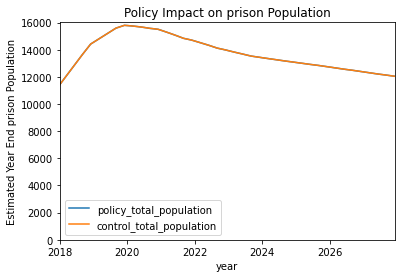

In [3]:
# DISAGGREGATION AXES
race = ['white', 'non-white']
crime_classification = ['drugs', 'residential burglary', 'second offense']

#SCENARIO
reallocation_fraction = 0.1

policy_list_non_retroactive = list()
policy_list_retroactive = list()

def apply_diversion(retroactive=False):
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=reallocation_fraction,
                   outflow='prison',
                   new_outflow='probation'
                  )

for crime in crime_classification:
    for demo in race:
        policy_list_non_retroactive.append(SparkPolicy(
            policy_fn=apply_diversion(retroactive=False),
            spark_compartment='pretrial',
            sub_population={'crime_type': crime, 'race': demo},
            apply_retroactive=False
        ))
        policy_list_retroactive.append(SparkPolicy(
            policy_fn=apply_diversion(retroactive=False),
            spark_compartment='pretrial',
            sub_population={'crime_type': crime, 'race': demo},
            apply_retroactive=True
        ))
        
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [7]:
a = pd.read_csv('testing.csv')
a

,outflow_to,0,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,prison,242.5,242.5,242.5,242.5,242.5,242.5,242.5,242.5,242.5,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [9]:
test_sim.pop_simulations['policy'].population_projections

,total_population,compartment,time_step,simulation_group
-182,228.640277,prison,-182,"('drugs', 'non-white')"
-181,457.280553,prison,-181,"('drugs', 'non-white')"
-180,685.920830,prison,-180,"('drugs', 'non-white')"
-179,914.561106,prison,-179,"('drugs', 'non-white')"
-178,1143.201383,prison,-178,"('drugs', 'non-white')"
...,...,...,...,...
175,19180.787380,release,175,"('second offense', 'white')"
176,19238.093170,release,176,"('second offense', 'white')"
177,19295.415129,release,177,"('second offense', 'white')"
178,19352.690411,release,178,"('second offense', 'white')"


In [7]:
a,b = test_results
a.to_csv('VA_mm_results_savings.csv')
b.to_csv('VA_mm_results_life_years.csv')